In [1]:
#IMPORTS

%run ../datuslib.ipynb
%run Functions.ipynb
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll import scope
from sklearn import datasets
from sklearn import pipeline
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler,scale, normalize
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydot
import time

# graficos incrustados
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def plotCM(cm,classes=None,title='Matriz de Confusion'):
    if classes is not None:
        sns.heatmap(cm,xticklabels=classes,yticklabels=classes,vmin=0.,vmax=1.,annot=True,annot_kws={'size':50})
    else:
        sns.heatmap(cm,vmin=0.,vmax=1.)
    plt.title(title)
    plt.ylabel('Etiqueta Verdadera')
    plt.xlabel('Etiqueta Predecida')
    
def checkDummyModel(xTrain,yTrain,xTest,yTest):
    dummyCf=DummyClassifier(strategy='most_frequent')
    dummyCf.fit(xTrain,yTrain)
    punjate=dummyCf.score(xTest,yTest)
    predict=dummyCf.predict(xTest)
    f1Score=f1_score(yTest,predict)
    print('Score:',punjate)
    print('f1Score:',f1Score)
    return predict

def runRF(rfModel,x_train,y_train,x_test,y_test,to_predict,perfect_sub):
    # ENTRENAMOS EL MODELO CON LOS DATOS
    rfModel.fit(x_train, y_train)

    # TOMAMOS LA IMPORTANCIA NUMERICA DE LOS FEATURES
    importances = list(rfModel.feature_importances_)
    feature_list = list(x_train.columns)

    # USAMOS EL MODELO PARA PREDECIR
    predictions = rfModel.predict(x_train)
    prediction_train_round= np.around(rfModel.predict(x_train))
    print ("F1 Score train: ", f1_score(y_train, prediction_train_round,average='micro'))

    predictions = rfModel.predict(x_test)
    prediction_test_round= np.around(rfModel.predict(x_test))
    print ("F1 Score test: ", f1_score(y_test, prediction_test_round,average='micro'))
    
    dummyPrediction=getDummyLabelToTest(y_test)
    print ("F1 Score dummy test: ", f1_score(y_test, dummyPrediction,average='micro'))

    prediction_to_predict_round= np.around(rfModel.predict(to_predict)).astype(int)
    f1real=f1_score(perfect_sub.target, prediction_to_predict_round,average='micro')
    print ("F1 Score to_predict: ",f1real)
    
    print ("F1 Score dummy perfect target: ",f1_score(perfect_sub.target, getDummyLabelToTest(perfect_sub.target),average='micro'))
    

    return [pd.Series(prediction_to_predict_round),feature_list,importances,rfModel.estimators_[5],f1real]

def graficarImportancia(feature_list,importances,title='Importancia de los Featuares'):
    # SETEAMOS EL ESTILO
    plt.style.use('fivethirtyeight')

    plt.figure(figsize=(20,10))

    # LISTA DE LOS VALORES DE X PARA PLOTTEAR
    x_values = list(range(len(importances)))


    # GENERAMOS EL GRAFICO DE BARRAS
    plt.bar(x_values, importances, orientation = 'vertical')

    # COLOCAMOS LAS ETIQUETAS PARA EL EJE X
    plt.xticks(x_values, feature_list, rotation='vertical')

    # ETIQUETAS DE EJES Y TITULO
    plt.ylabel('Importancia'); plt.xlabel('Features'); plt.title(title)
    
    
def tomarXfeaturesImportantes(cantidadFeateares,feature_list,importances):
    df_feature_importance=pd.DataFrame(importances)
    df_feature_importance['feature']=feature_list
    df_feature_importance.columns=['Importancia','Features']
    df_feature_importance=df_feature_importance[['Features','Importancia']]
    return df_feature_importance.nlargest(cantidadFeateares,'Importancia')

def exportarArbolEjemplo(estimador,lista_features,nombreSalida='tree.png'):
    export_graphviz(estimador, out_file = 'tree.dot', feature_names = lista_features, rounded = True, precision = 1)
    (graph, ) = pydot.graph_from_dot_file('tree.dot')

    # GUARDAMOS EL GRAFICO EN EL ARCHIVO PNG
    graph.write_png(nombreSalida)
    
def getDummyLabelToTest(serieToTest):
    valor_mas_frecuente=pd.Series(serieToTest).value_counts().idxmax()
    return pd.Series(valor_mas_frecuente).repeat(len(serieToTest))

def estandarizarDF(dataframe):
    
    nombreColumnas = dataframe.columns
    # CREO EL OBJETO STANDARSCALER
    scaler = preprocessing.StandardScaler()

    # TRANSFORMO LOS VALORES
    standarScaledDF = scaler.fit_transform(dataframe)
    scaled_df = pd.DataFrame(standarScaledDF, columns=nombreColumnas)
    return scaled_df

In [3]:
perfect_sub = pd.read_csv("../Data/perfect_submission.csv")
train=pd.read_csv('train_feature_merged.csv')
to_predict=pd.read_csv('to_predict_feature_merged.csv')
to_predict.drop('id',axis=1,inplace=True)

In [4]:
x = train.drop(columns=['id','target'])
y = train['target']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25,random_state=42,shuffle=True)

print(f"Original shapes: X={x.shape} y={y.shape}")
print(f"Train shapes: X={x_train.shape} y={y_train.shape}")
print(f"Test  shapes: X={x_test.shape}  y={y_test.shape}")

Original shapes: X=(7613, 247) y=(7613,)
Train shapes: X=(5709, 247) y=(5709,)
Test  shapes: X=(1904, 247)  y=(1904,)


# CARGO LOS FEATURES

to_predict=pd.read_csv('to_predict.csv')
to_predict=to_predict*1
print (to_predict.shape)
#to_predict=estandarizarDF(to_predict)
to_predict.head()

x_train=pd.read_csv('x_train.csv')
x_train=x_train*1
print (x_train.shape)
#x_train=estandarizarDF(x_train)
x_train.head()

x_test=pd.read_csv('x_test.csv')
x_test=x_test*1
print (x_test.shape)
#x_test=estandarizarDF(x_test)
x_test.head()

y_train=pd.read_csv('y_train.csv')
y_train=y_train.target
print (y_train.shape)
y_train.head()

y_test=pd.read_csv('y_test.csv')
y_test=y_test.target
print (y_test.shape)
y_test.head()

In [5]:
ids=pd.read_csv('ids.csv')
ids=ids.id
print (ids.shape)
ids.head()

(3263,)


0     0
1     2
2     3
3     9
4    11
Name: id, dtype: int64

# COMIENZO CON EL ALGORITMO

In [6]:
from sklearn.ensemble import RandomForestRegressor

# INSTANCIAMOS EL MODELO ESTANDAR

rfr = RandomForestRegressor(random_state=42)
rf_result=runRF(rfr,x_train,y_train,x_test,y_test,to_predict,perfect_sub)

rf_predict=rf_result[0]
feature_list=rf_result[1]
importances=rf_result[2]
estimador=rf_result[3]
score_base=rf_result[4]

F1 Score train:  0.9963215974776668
F1 Score test:  0.9663865546218487
F1 Score dummy test:  0.5730042016806722
F1 Score to_predict:  0.7116150781489426
F1 Score dummy perfect target:  0.5703340484216978


# GRAFICO DE IMPORTANCIA DE LOS FEATURES

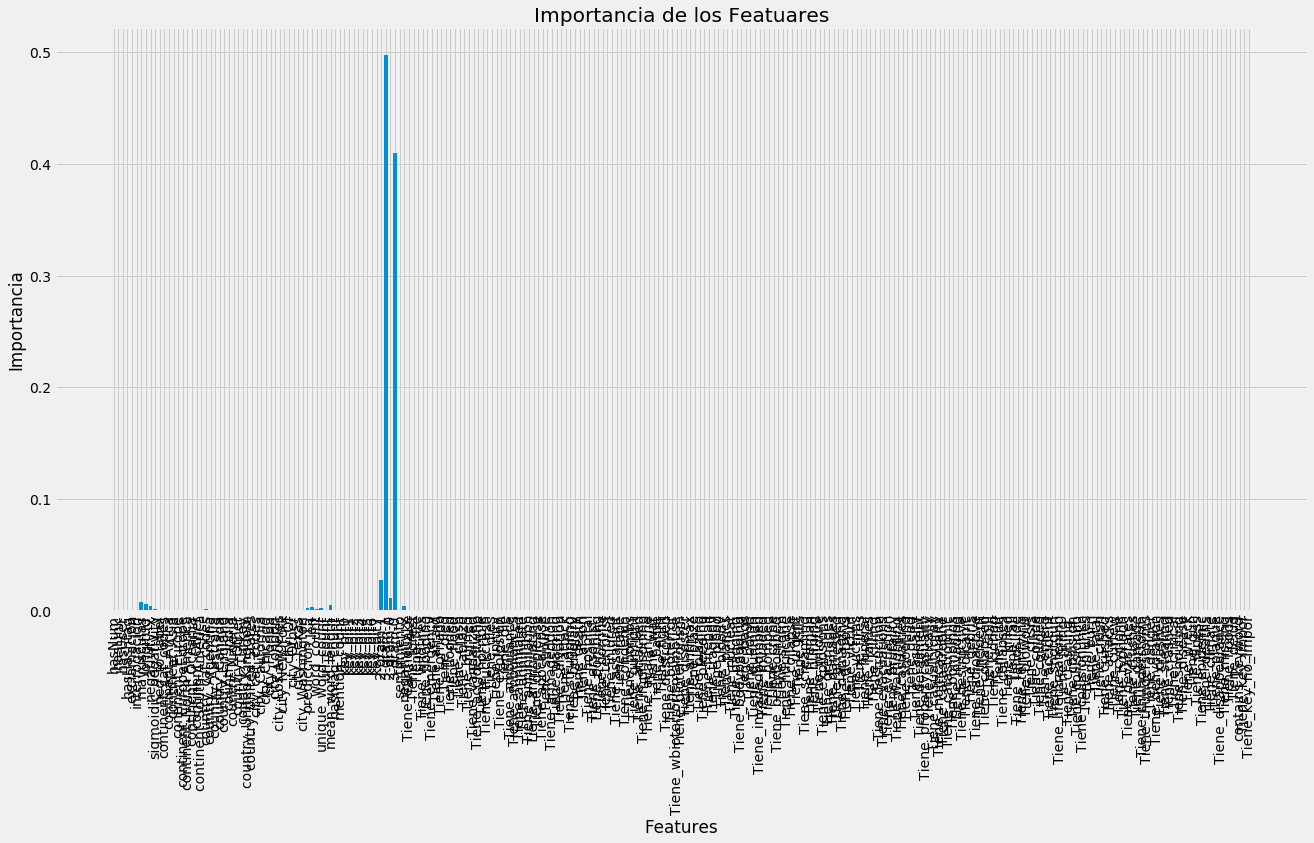

In [7]:
graficarImportancia(feature_list,importances)

# Verifico el top 40 de los Features mas importantes

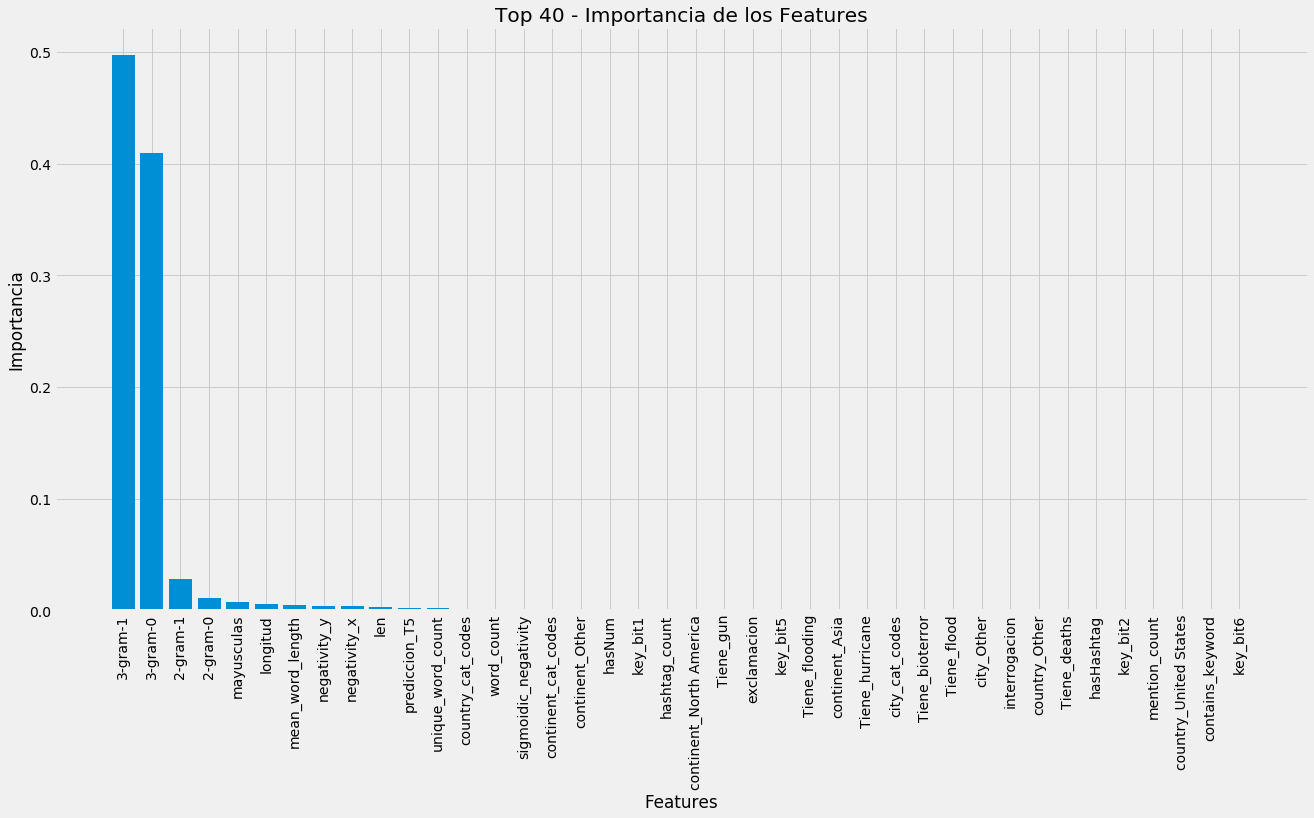

In [8]:
df_top_40_features=tomarXfeaturesImportantes(40,feature_list,importances)
graficarImportancia(df_top_40_features.Features,df_top_40_features.Importancia,'Top 40 - Importancia de los Features')

# Visualizo los features del 10 al 40

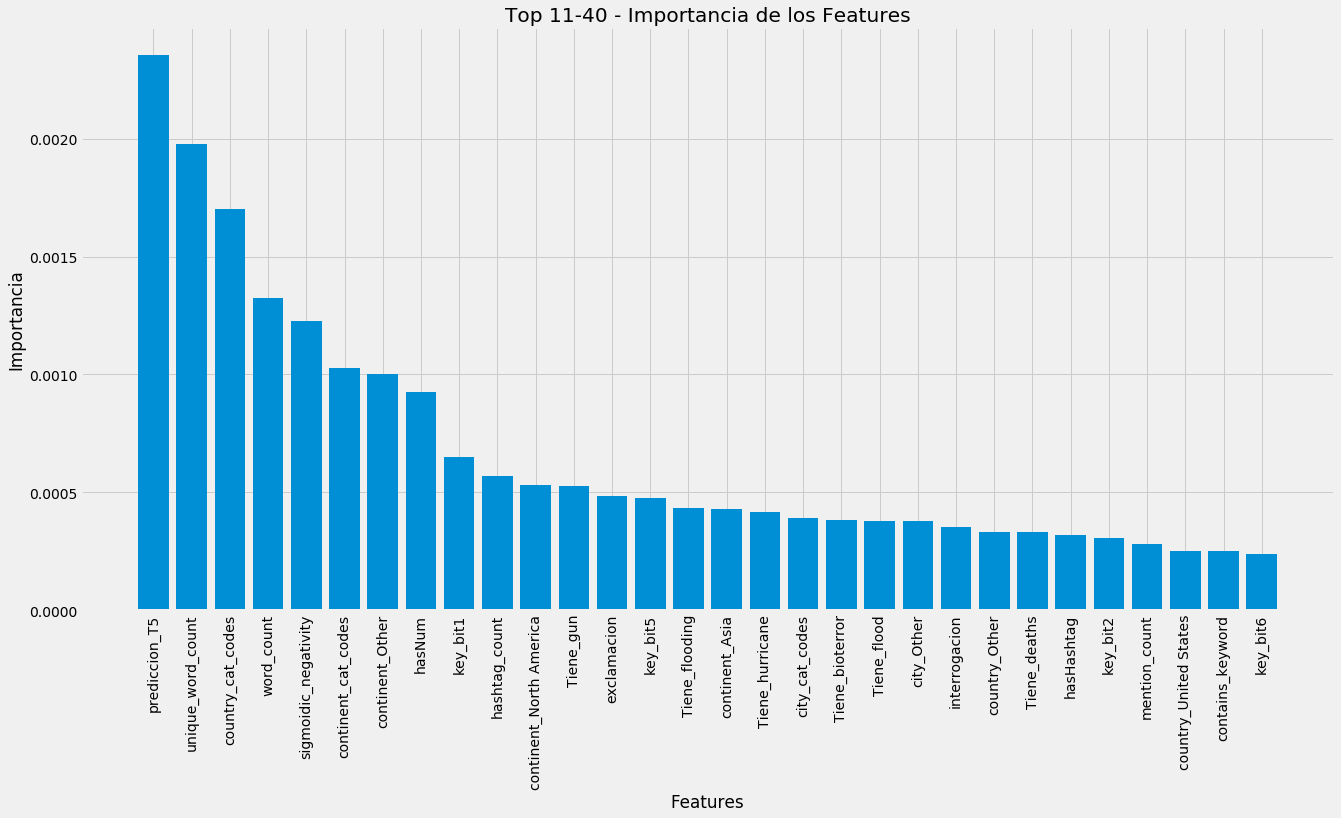

In [9]:
graficarImportancia(df_top_40_features.Features[10:],df_top_40_features.Importancia[10:],'Top 11-40 - Importancia de los Features')

# SUBMIT DE MODELO BASE

In [10]:
#SUBMIT DE MODELO BASE
result = submission_output(ids, rf_predict,"RF_BASE.csv")
result.head()

,id,target
0,0,0
1,2,1
2,3,0
3,9,0
4,11,0


# PRUEBA DE RANDOM FOREST CON LOS 20 FEATURES MAS IMPORTANTES

In [11]:
df_top_20_features=tomarXfeaturesImportantes(20,feature_list,importances)
feature_list_top_20 = df_top_20_features.Features.to_list()

to_predict_top_20=to_predict.loc[:,feature_list_top_20]
print (to_predict_top_20.shape)
print('-----------')
x_train_top_20=x_train.loc[:,feature_list_top_20]
print ('x_train_top_20:',x_train_top_20.shape)
print('-----------')
print ('y_train:',y_train.shape)
print('-----------')
x_test_top_20=x_test.loc[:,feature_list_top_20]
print ('x_test_top_20:',x_test_top_20.shape)
print('-----------')
print ('y_test:',y_test.shape)
print('-----------')

#ENTRENO MODELO BASE REDUCIDO
rfr = RandomForestRegressor(random_state=42)

result_top_20=runRF(rfr,x_train_top_20,y_train,x_test_top_20,y_test,to_predict_top_20,perfect_sub)
print('Top 20 features y Diferencia entre score Base:',result_top_20[4]-score_base)

(3263, 20)
-----------
x_train_top_20: (5709, 20)
-----------
y_train: (5709,)
-----------
x_test_top_20: (1904, 20)
-----------
y_test: (1904,)
-----------
F1 Score train:  0.9959712734279208
F1 Score test:  0.967436974789916
F1 Score dummy test:  0.5730042016806722
F1 Score to_predict:  0.7235672693840023
F1 Score dummy perfect target:  0.5703340484216978
Top 20 features y Diferencia entre score Base: 0.01195219123505964


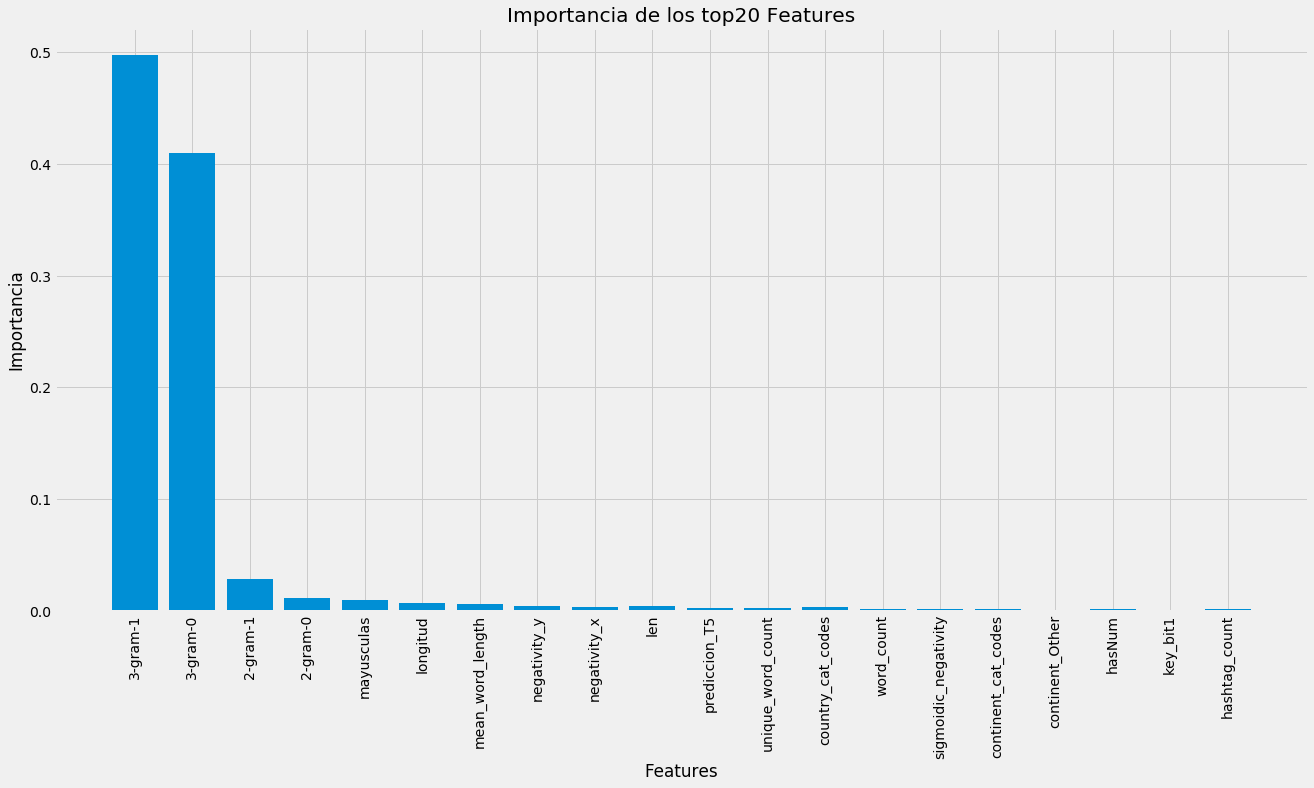

In [12]:
graficarImportancia(result_top_20[1],result_top_20[2],'Importancia de los top20 Features')

# VEO COMO ES UN ARBOL MODELO

In [13]:
exportarArbolEjemplo(result_top_20[3],result_top_20[1],'arbol_ejemplo_top_20_feature.png')

# ----------------------------------------------------------------------

# ----------------------------------------------------------------------

# ----------------------------------------------------------------------

# TUNEO EL MODELO

In [16]:
results=[]
best_results=[]
all_params=[]
temporal_best = 0

# PRUEBO UN KNN BUSCANDO LOS N VECINOS PARA VER COMO SE COMPORTA RF

In [31]:
Y=np.log(abs(X)+1)
Y.append(X)

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [23]:
X.plot()
df_n_knn=pd.DataFrame(X)
df_n_knn=df_n_knn.reset_index()
df_n_knn['index']=df_n_knn.index+1
df_n_knn.columns=['Iteracion','Neighbors']
df_n_knn.plot.scatter('Iteracion','Neighbors')

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

In [39]:
result

          fun: 0.0
    func_vals: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
       models: [GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=1**2 * Matern(length_scale=[1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, optimizer='fmin_l_bfgs_b',
                         random_state=817522031), GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=1**2 * Matern(length_scale=[1, 1], nu=2.5) + WhiteKernel(noise_level=

In [63]:
# example of bayesian optimization with scikit-optimize
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from skopt.space import Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

resultados=[]

X=x_train
y=y_train
# define the model
model = KNeighborsClassifier()
# define the space of hyperparameters to search
search_space = [Integer(1, 150, name='n_neighbors'), Integer(1, 2, name='p')]
 
# define the function used to evaluate a given configuration
@use_named_args(search_space)
def evaluate_model(**params):
    # something
    model.set_params(**params)
    # calculate 5-fold cross validation
    result = cross_val_score(model, X, y, cv=5, n_jobs=-1, scoring='f1_micro')
    # calculate the mean of the scores
    estimate = mean(result)
    resultados.append(estimate)
    return 1.0 - estimate
 
# perform optimization
result = gp_minimize(evaluate_model, search_space)
# summarizing finding:
print('Best Accuracy: %.3f' % (1.0 - result.fun))
print('Best Parameters: n_neighbors=%d, p=%d' % (result.x[0], result.x[1]))

C:\Users\Mauro\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mauro\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mauro\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mauro\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mauro\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mauro\

C:\Users\Mauro\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mauro\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mauro\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mauro\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mauro\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mauro\

Best Accuracy: 0.958
Best Parameters: n_neighbors=19, p=1


In [64]:
result

          fun: 0.04186392616387169
    func_vals: array([0.08145176, 0.06411145, 0.05237243, 0.08232696, 0.05482534,
       0.04939642, 0.07006638, 0.05114743, 0.05097229, 0.04852076,
       0.05184749, 0.05184749, 0.05990569, 0.05570069, 0.05184749,
       0.05184749, 0.05184749, 0.05570069, 0.05990569, 0.05570069,
       0.04834502, 0.04834502, 0.05184749, 0.04939642, 0.05184749,
       0.05990569, 0.05570069, 0.04887118, 0.04922175, 0.05184749,
       0.05027146, 0.05184749, 0.04922175, 0.04922175, 0.05570069,
       0.04922175, 0.05990569, 0.05184749, 0.05202232, 0.05184749,
       0.05570069, 0.05202247, 0.05184749, 0.04852091, 0.04852091,
       0.05990569, 0.04852091, 0.04852091, 0.04852091, 0.05254817,
       0.05570069, 0.05184749, 0.04852076, 0.05254817, 0.05184749,
       0.05254817, 0.04834502, 0.05570069, 0.05184749, 0.05990569,
       0.04834502, 0.05254786, 0.06691294, 0.05184749, 0.05254786,
       0.05570069, 0.04799491, 0.05254817, 0.04589302, 0.04571804,
       0.046

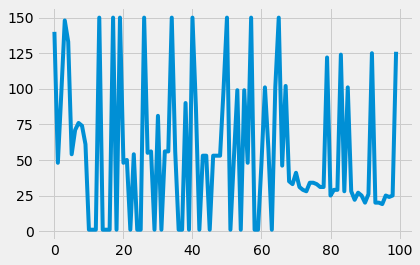

In [65]:
iter_neighbors=[]
iter_power=[]
for elem in range (0,len(result.x_iters)):
    iter_neighbors.append(result.x_iters[elem][0])
    iter_power.append(result.x_iters[elem][1])

plt.plot(iter_neighbors)

Text(0.5, 1.0, 'Optimizacion Bayesiana')

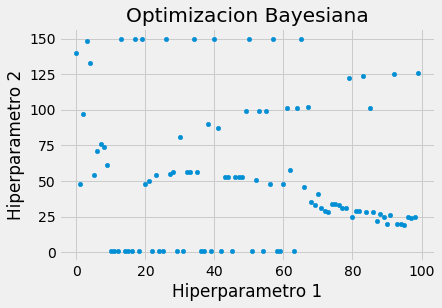

In [133]:

dataFRAME=pd.DataFrame([iter_neighbors,range (0,len(iter_neighbors))]).T
dataFRAME.columns=['Hiperparametro 2','Hiperparametro 1']
dataFRAME.plot.scatter('Hiperparametro 1','Hiperparametro 2')
plt.title('Optimizacion Bayesiana')

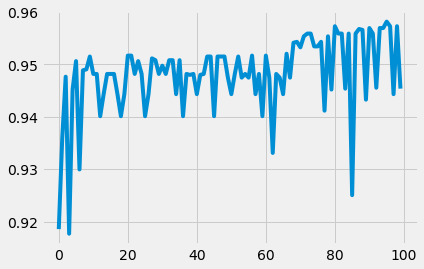

In [66]:
plt.plot(resultados)

In [20]:
def hyperopt_train_test(params):
    clf = KNeighborsClassifier(**params)
    return cross_val_score(clf, x_train, y_train,scoring='f1',cv=5).mean()

space4knn = {
    'n_neighbors': hp.choice('n_neighbors', range(1,111))
}

results=[]
best_results=[]
all_params=[]
best = 0
def f(params):
    global best
    acc = hyperopt_train_test(params)
    results.append(acc)
    all_params.append(params['n_neighbors'])
    if acc > best:
        best = acc
        best_results.append(acc)
    print ('new best:', best, params)
    return {'loss': 1-acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4knn, algo=tpe.suggest, max_evals=50, trials=trials)
print ('best:')
print (best)

new best:                                                                                                              
0.9077832176246572                                                                                                     
{'n_neighbors': 110}                                                                                                   
new best:                                                                                                              
0.9328252100809952                                                                                                     
{'n_neighbors': 26}                                                                                                    
new best:                                                                                                              
0.9328252100809952                                                                                                     
{'n_neighbors': 41}                     

{'n_neighbors': 33}                                                                                                    
new best:                                                                                                              
0.9380521387283188                                                                                                     
{'n_neighbors': 12}                                                                                                    
new best:                                                                                                              
0.942679309881003                                                                                                      
{'n_neighbors': 3}                                                                                                     
new best:                                                                                                              
0.942679309881003                       

0.942679309881003                                                                                                      
{'n_neighbors': 86}                                                                                                    
new best:                                                                                                              
0.942679309881003                                                                                                      
{'n_neighbors': 62}                                                                                                    
new best:                                                                                                              
0.942679309881003                                                                                                      
{'n_neighbors': 61}                                                                                                    
new best:                               

In [16]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

Text(0.5, 1.0, 'N seleccionados (Bayesian Optimization)')

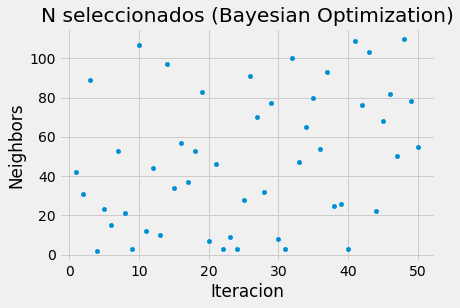

In [18]:
df_n_knn=pd.DataFrame(all_params)
df_n_knn=df_n_knn.reset_index()
df_n_knn['index']=df_n_knn.index+1
df_n_knn.columns=['Iteracion','Neighbors']
df_n_knn.plot.scatter('Iteracion','Neighbors')
plt.title('N seleccionados (Bayesian Optimization)')
    

Text(0.5, 1.0, 'N seleccionados (Variacion lineal)')

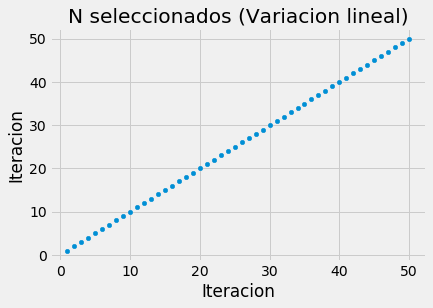

In [19]:
df_n_knn.plot.scatter('Iteracion','Iteracion')
plt.title('N seleccionados (Variacion lineal)')

In [20]:
knn=KNeighborsClassifier(n_neighbors=2)
# Fitting the model
knn.fit(x_train, y_train)

# Predicting the Test set results
y_pred = knn.predict(x_train)
f1_score(y_train, y_pred,average='micro')

0.9677701874233666

In [21]:
knn_pred=knn.predict(to_predict)
knn_pred

array([0, 1, 0, ..., 1, 0, 1], dtype=int64)

In [22]:
f1_score(perfect_sub.target, knn_pred,average='micro')

0.7266319338032485

In [24]:
knn_tunning=submission_output(ids, knn_pred,"knn_tunning.csv")
knn_tunning.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,1


In [80]:
# example of bayesian optimization with scikit-optimize
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

resultados=[]

X=x_train
y=y_train
# define the model
model = RandomForestClassifier()
# define the space of hyperparameters to search
search_space = [Integer(1, 20, name='max_depth'),Integer(1, 150, name='max_features'),
                Integer(100, 250, name='n_estimators'),Categorical(['gini', 'entropy'], name='criterion')]


# define the function used to evaluate a given configuration
@use_named_args(search_space)
def evaluate_model(**params):
    # something
    model.set_params(**params)
    # calculate 5-fold cross validation
    result = cross_val_score(model, X, y, cv=5, n_jobs=-1, scoring='f1_micro')
    # calculate the mean of the scores
    estimate = mean(result)
    resultados.append(estimate)
    return 1.0 - estimate
 
# perform optimization
result = gp_minimize(evaluate_model, search_space)
# summarizing finding:
print('Best Accuracy: %.3f' % (1.0 - result.fun))
print('Best Parameters: max_depth=%d, max_features=%d' % (result.x[0], result.x[1]))

C:\Users\Mauro\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mauro\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mauro\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mauro\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mauro\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mauro\

Best Accuracy: 0.973
Best Parameters: max_depth=5, max_features=93


In [81]:
result0=result
resultados0=resultados
result0

          fun: 0.027150433567866727
    func_vals: array([0.029953  , 0.03030326, 0.02890236, 0.03397964, 0.03433021,
       0.03065352, 0.03888639, 0.03450519, 0.03398041, 0.04764388,
       0.03275495, 0.03275433, 0.05027806, 0.03485591, 0.0390609 ,
       0.0331046 , 0.03450534, 0.42476947, 0.04256645, 0.03152872,
       0.03187944, 0.02837681, 0.11946263, 0.02715043, 0.03380558,
       0.03380558, 0.078997  , 0.03082835, 0.03485576, 0.0334544 ,
       0.03555797, 0.03363076, 0.032931  , 0.02767598, 0.03362922,
       0.02802548, 0.03258073, 0.03275357, 0.06516131, 0.06410746,
       0.03047839, 0.03468139, 0.03345532, 0.03310536, 0.03345409,
       0.03170431, 0.0327551 , 0.03152949, 0.03187944, 0.03187913,
       0.03362999, 0.03293008, 0.03222924, 0.03433082, 0.03135328,
       0.03223001, 0.03363045, 0.03275494, 0.03415584, 0.02767675,
       0.03188021, 0.03363014, 0.03380558, 0.03503196, 0.0341563 ,
       0.031704  , 0.03240438, 0.03398087, 0.03310429, 0.03275479,
       0.03

In [91]:
print (x_train.shape)
print (np.sqrt(np.sqrt(x_train.shape)))
np.sqrt(x_train.shape)

(5709, 247)
[8.69240616 3.96437052]


array([75.5579248 , 15.71623365])

In [97]:
# example of bayesian optimization with scikit-optimize
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

resultados=[]

X=x_train
y=y_train
# define the model
model = RandomForestClassifier()
# define the space of hyperparameters to search
search_space = [Integer(1, 50, name='max_depth'),Integer(1, 150, name='max_features'),
                Integer(1, 4000, name='min_samples_leaf'),Integer(2, 200, name='max_leaf_nodes'),
                Integer(2, 5000, name='min_samples_split'),#Real(0, 1, name='max_samples'),
                Integer(100, 600, name='n_estimators'),Categorical(['gini', 'entropy'], name='criterion')]


# define the function used to evaluate a given configuration
@use_named_args(search_space)
def evaluate_model(**params):
    # something
    model.set_params(**params)
    # calculate 5-fold cross validation
    result = cross_val_score(model, X, y, cv=5, n_jobs=-1, scoring='f1_micro')
    # calculate the mean of the scores
    estimate = mean(result)
    resultados.append(estimate)
    return 1.0 - estimate
 
# perform optimization
result = gp_minimize(evaluate_model, search_space)
# summarizing finding:
print('Best Accuracy: %.3f' % (1.0 - result.fun))
print('Best Parameters: max_depth=%d, max_features=%d, min_samples_leaf=%d, max_leaf_nodes=%d, min_samples_split=%d, n_estimators=%d, criterion=%s' % (result.x[0], result.x[1], result.x[2], result.x[3], result.x[4], result.x[5], result.x[6]))

Best Accuracy: 0.971
Best Parameters: max_depth=50, max_features=89, min_samples_leaf=1, max_leaf_nodes=200, min_samples_split=1103, n_estimators=100, criterion=gini


In [98]:
model.get_params().keys()

dict_keys(['bootstrap', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [102]:
results=[]
params_list=[]
best_results=[]
def acc_model(params):
    clf = RandomForestClassifier(**params)
    return cross_val_score(clf, x_train, y_train,scoring='f1_micro',cv=5).mean()

param_space = {
    'max_depth': hp.choice('max_depth', range(1,20)),
    'max_features': hp.choice('max_features', range(1,150)),
    'n_estimators': hp.choice('n_estimators', range(100,500)),
    'criterion': hp.choice('criterion', ["gini", "entropy"]),
    'random_state': hp.choice('random_state', [42])}

best = 0
def f(params):
    global best
    params_list.append(params)
    acc = acc_model(params)
    results.append(acc)
    if acc > best:
        best = acc
        best_results.append(acc)
    else:
        best_results.append(best_results[-1])
    print ('new best:', best, params)
    return {'loss': 1-acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, param_space, algo=tpe.suggest, max_evals=100, trials=trials)
print ('best:')
print (best)

new best:                                                                                                              
0.966194879481673                                                                                                      
{'criterion': 'gini', 'max_depth': 17, 'max_features': 19, 'n_estimators': 354, 'random_state': 42}                    
new best:                                                                                                              
0.966194879481673                                                                                                      
{'criterion': 'entropy', 'max_depth': 13, 'max_features': 77, 'n_estimators': 293, 'random_state': 42}                 
new best:                                                                                                              
0.9684706682248023                                                                                                     
{'criterion': 'entropy', 'max_depth': 9,

{'criterion': 'gini', 'max_depth': 6, 'max_features': 3, 'n_estimators': 358, 'random_state': 42}                      
new best:                                                                                                              
0.9726748952830994                                                                                                     
{'criterion': 'gini', 'max_depth': 8, 'max_features': 6, 'n_estimators': 269, 'random_state': 42}                      
new best:                                                                                                              
0.9726748952830994                                                                                                     
{'criterion': 'gini', 'max_depth': 6, 'max_features': 58, 'n_estimators': 366, 'random_state': 42}                     
new best:                                                                                                              
0.9726748952830994                      

0.9728494132113559                                                                                                     
{'criterion': 'entropy', 'max_depth': 8, 'max_features': 47, 'n_estimators': 487, 'random_state': 42}                  
new best:                                                                                                              
0.9728494132113559                                                                                                     
{'criterion': 'gini', 'max_depth': 9, 'max_features': 103, 'n_estimators': 313, 'random_state': 42}                    
new best:                                                                                                              
0.9728494132113559                                                                                                     
{'criterion': 'entropy', 'max_depth': 7, 'max_features': 32, 'n_estimators': 380, 'random_state': 42}                  
new best:                               

new best:                                                                                                              
0.9728494132113559                                                                                                     
{'criterion': 'gini', 'max_depth': 6, 'max_features': 148, 'n_estimators': 314, 'random_state': 42}                    
new best:                                                                                                              
0.9728494132113559                                                                                                     
{'criterion': 'gini', 'max_depth': 18, 'max_features': 54, 'n_estimators': 109, 'random_state': 42}                    
new best:                                                                                                              
0.9728494132113559                                                                                                     
{'criterion': 'gini', 'max_depth': 19, '

{'criterion': 'gini', 'max_depth': 8, 'max_features': 139, 'n_estimators': 351, 'random_state': 42}                    
new best:                                                                                                              
0.9733751145041631                                                                                                     
{'criterion': 'gini', 'max_depth': 18, 'max_features': 143, 'n_estimators': 297, 'random_state': 42}                   
new best:                                                                                                              
0.9733751145041631                                                                                                     
{'criterion': 'gini', 'max_depth': 10, 'max_features': 71, 'n_estimators': 249, 'random_state': 42}                    
new best:                                                                                                              
0.9733751145041631                      

In [103]:
best

{'criterion': 0,
 'max_depth': 4,
 'max_features': 62,
 'n_estimators': 129,
 'random_state': 0}

Text(0.5, 1.0, 'Resultado de entrenamiento')

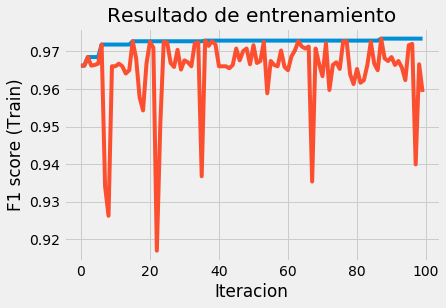

In [106]:
plt.plot(best_results)
plt.plot(results)
plt.xlabel('Iteracion')
plt.ylabel('F1 score (Train)')
plt.title('Resultado de entrenamiento')

In [100]:
clf = RandomForestClassifier(max_depth=50, max_features=89, min_samples_leaf=1, max_leaf_nodes=200, min_samples_split=1103, n_estimators=100, criterion='gini')
clf.fit(x_train, y_train)
PREDICCIONTUNEADA=clf.predict(to_predict)
PREDICCIONTUNEADA

array([0, 1, 0, ..., 1, 1, 1], dtype=int64)

In [101]:
comprobar(PREDICCIONTUNEADA)

F1 Score:  0.7180508734293595
F1 Score default:  0.556840077071291


# VERIFICO TUNEO DEL MODELO

In [31]:
clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=7, max_features=55, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=265,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [134]:
evaluate(clf, x_train,y_train, x_test, y_test)
f1_score(perfect_sub.target,PREDICCIONTUNEADA,average='micro')



Entrenamiento: 96.6719%
Testeo: 96.5336%.
F1 Score:  0.9653361344537815
F1 Score default:  0.9579081632653063


0.7180508734293595

# GENERO EL SUBMIT

In [135]:
result = submission_output(ids, PREDICCIONTUNEADA,"RF_tunning3.csv")
result.head()

,id,target
0,0,0
1,2,1
2,3,0
3,9,0
4,11,0


In [ ]:
[Integer(1, 50, name='max_depth'),Integer(1, 150, name='max_features'),
                Integer(1, 4000, name='min_samples_leaf'),Integer(2, 200, name='max_leaf_nodes'),
                Integer(2, 5000, name='min_samples_split'),#Real(0, 1, name='max_samples'),
                Integer(100, 600, name='n_estimators'),Categorical(['gini', 'entropy'], name='criterion')]


Text(0.5, 1.0, 'Busqueda de max_depth')

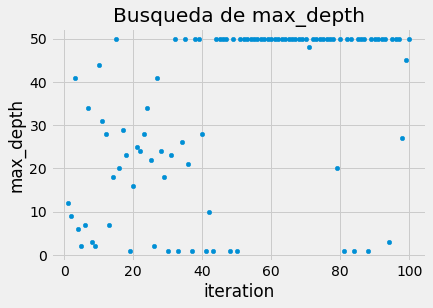

In [127]:
resultDF=pd.DataFrame(result.x_iters).reset_index()
resultDF.columns=['iteration','max_depth','max_features','min_samples_leaf','max_leaf_nodes','min_samples_split','n_estimators','criterion']
resultDF['iteration']=resultDF['iteration']+1
resultDF['criterion']=resultDF.apply(lambda x: 1 if (x.criterion=='gini') else 2,axis=1)
resultDF.plot.scatter('iteration','max_depth')
plt.title('Busqueda de max_depth')

Text(0.5, 1.0, 'Busqueda de max_features')

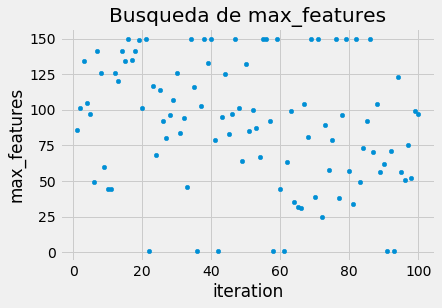

In [128]:
resultDF.plot.scatter('iteration','max_features')
plt.title('Busqueda de max_features')

Text(0.5, 1.0, 'Busqueda de min_samples_leaf')

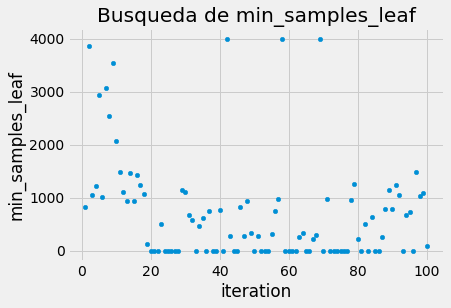

In [132]:
resultDF.plot.scatter('iteration','min_samples_leaf')
plt.title('Busqueda de min_samples_leaf')

Text(0.5, 1.0, 'Busqueda de max_leaf_nodes')

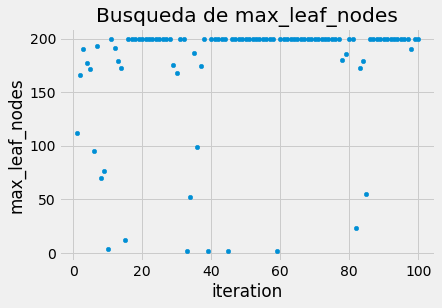

In [131]:
resultDF.plot.scatter('iteration','max_leaf_nodes')
plt.title('Busqueda de max_leaf_nodes')

Text(0.5, 1.0, 'Busqueda de min_samples_split')

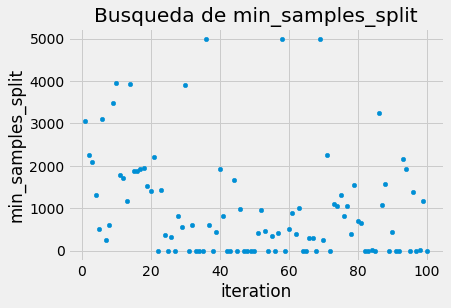

In [130]:
resultDF.plot.scatter('iteration','min_samples_split')
plt.title('Busqueda de min_samples_split')

In [ ]:
resultDF.plot.scatter('iteration','n_estimators')
plt.title('Busqueda de n_estimators')

Text(0.5, 1.0, 'Busqueda de criterion (1=gini | 2=entropy)')

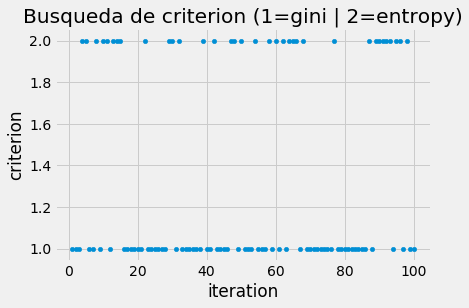

In [129]:
resultDF.plot.scatter('iteration','criterion')
plt.title('Busqueda de criterion (1=gini | 2=entropy)')